# Modelos Series de Tiempo Car Sales
Universidad del Valle de Guatemala
1. Pablo Gonzalez 20362
2. Javier Mombiela 20067

In [36]:
from Def_funciones import *

import pandas as pd
from numpy import mean
from numpy import median
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error

#
from warnings import catch_warnings
from warnings import filterwarnings

# La librería statsmodel tiene implementaciones de SARIMA y de Holt-Winters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Si el computador tiene procesadores múltiples, se aprovecharán
#from multiprocessing import cpu_count

from multiprocess import cpu_count
from joblib import Parallel

from joblib import delayed


In [2]:
data = pd.read_csv('data/monthly-car-sales.csv')
data.dtypes

Month    object
Sales     int64
dtype: object

In [3]:
data.info


<bound method DataFrame.info of        Month  Sales
0    1960-01   6550
1    1960-02   8728
2    1960-03  12026
3    1960-04  14395
4    1960-05  14587
..       ...    ...
103  1968-08  16722
104  1968-09  14385
105  1968-10  21342
106  1968-11  17180
107  1968-12  14577

[108 rows x 2 columns]>

In [4]:
data.shape

(108, 2)

In [5]:
pd.set_option('display.width',100)
pd.set_option('display.precision',3)
data.describe()

,Sales
count,108.000
mean,14595.111
std,4525.214
min,5568.000
25%,11391.250
50%,14076.000
75%,17595.750
max,26099.000


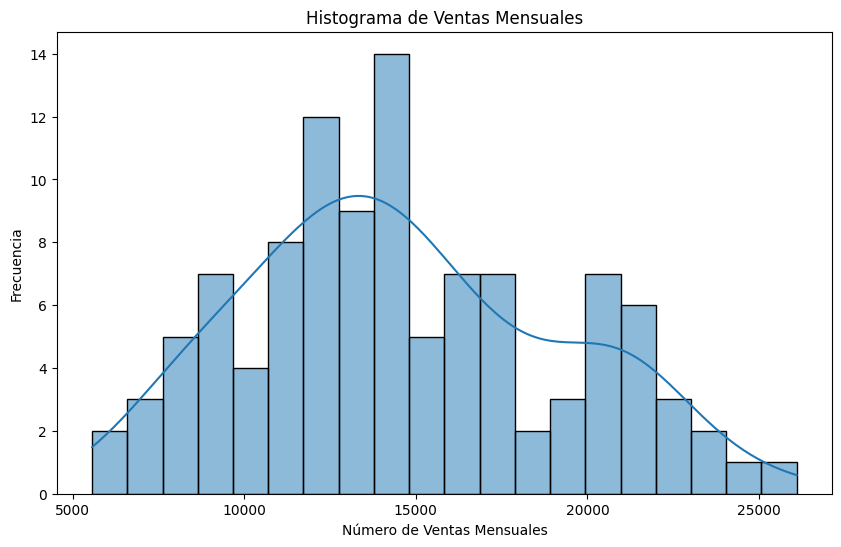

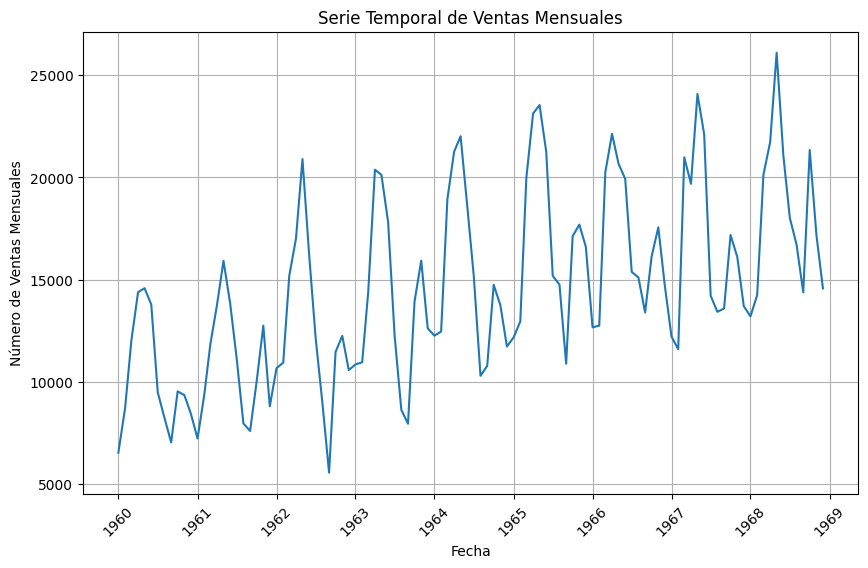

In [8]:
# Histograma de nacimientos
plt.figure(figsize=(10, 6))
sns.histplot(data["Sales"], bins=20, kde=True)
plt.xlabel("Número de Ventas Mensuales")
plt.ylabel("Frecuencia")
plt.title("Histograma de Ventas Mensuales")
plt.show()


data['Month'] = pd.to_datetime(data['Month'])

# Establecer la columna 'Month' como índice (opcional, pero puede ser útil)
data.set_index('Month', inplace=True)

# Serie temporal de ventas mensuales
plt.figure(figsize=(10, 6))
sns.lineplot(x=data.index, y=data["Sales"])
plt.xlabel("Fecha")
plt.ylabel("Número de Ventas Mensuales")
plt.title("Serie Temporal de Ventas Mensuales")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [9]:
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

In [10]:
def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

In [11]:
def busqueda_malla(datos, lista_cfg, n_prueba, metodo = "sarima", paralelo = True):
    resultados = None
    if paralelo:
        # ejecutar las configuraciones en paralelo
        executor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing') 
        tareas = (delayed(calificar_modelo)(datos, n_prueba, metodo, cfg) for cfg in lista_cfg) 
        resultados = executor(tareas)
    else:
        resultados = [calificar_modelo(datos, n_prueba, metodo, cfg) for cfg in lista_cfg]
    # eliminar resultados vacíos
    resultados = [r for r in resultados if r[1] != None]
    return resultados

In [12]:
def validacion_al_frente(datos, n_prueba, metodo, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        if metodo == "promedio":
            yhat = prediccion_promedio(historia, cfg)
        elif metodo == "sarima":
            yhat = prediccion_sarima(historia, cfg)
        elif metodo == "exp":
            yhat = prediccion_alisamiento_exp(historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    return [error, predicciones]

In [13]:
def calificar_modelo(datos, n_prueba, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir la confiuración a una llave
    llave = str(cfg)
    if debug:
        resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
    else:
        # una falla durante la validación del modelo sugiere una configuración inestable
        try:
        # nunca mostrar advertencias cuando se busca en malla...demasiado "ruido"
            with catch_warnings():
                filterwarnings("ignore")
                resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
        except:
            error = None
    if resultado is not None:
        print(f' > Modelo{llave} {resultado:.3f}')
    return (llave, resultado, predicciones)

In [14]:
def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    # dividir los datos
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos
    if metodo == "sarima":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_sarima()
    elif metodo == "promedio":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_simple(long_max)
    elif metodo == "exp":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_alisamiento_exp()
        datos = datos[:,0]
    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
    else:
        # búsqueda en malla
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo)
        
    
    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])


    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
    # Esconder las líneas de malla de la gráfica
    # ax.grid(False)

    # Esconder las marcas en los ejes
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()

In [15]:
def config_simple(long_max, offsets = [1]):
    configs = []
    for i in range(1, long_max + 1):
        for t in ['mediana',"promedio"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# prediccion de un paso por promedio
def prediccion_promedio(historia, config):
    n, tipo_promedio = config
    if tipo_promedio == 'promedio':
        return mean(historia[-n:])
    return median(historia[-n:])

In [16]:
def prediccion_sarima(historia, config):
    orden, orden_estacional, tendencia = config
    # definir el modelo
    modelo = SARIMAX(historia, order = orden, seasonal_order = orden_estacional, trend = tendencia,
      enforce_stationarity = False, enforce_invertibility = False)
    # ajustar el model con los datos
    modelo_ajustado = modelo.fit(disp = False)
    # hacer la predicción de un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_sarima(estacional=[0]):
    modelos = []
    # definir las listas de configuración
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n', 'c', 't', 'ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]

    # Si m es mayor que cero, generar configuraciones estacionales
    m_params = estacional

    # crear instancias de configuración
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p, d, q), (P, D, Q, m), t]
                                    modelos.append(cfg)
    return modelos


In [17]:
def prediccion_alisamiento_exp(historia, configuracion):
    # Crear una serie de tiempo a partir de la historia
    serie_tiempo = pd.Series(historia)
    
    # Aplicar el modelo de Holt-Winters exponencial
    modelo = ExponentialSmoothing(serie_tiempo, 
                                  trend=configuracion[0], 
                                  seasonal=configuracion[1], 
                                  seasonal_periods=configuracion[2])
    
    # Ajustar el modelo a los datos históricos
    modelo_ajustado = modelo.fit()
    
    # Realizar una predicción de un paso hacia adelante
    prediccion = modelo_ajustado.forecast(steps=1)
    
    return prediccion[0]

def config_alisamiento_exp(estacional = [None]): 
    modelos = []
    # definir las listas de config
    t_params = ['add', 'mul', None]
    d_params = [True, False] 
    s_params = ['add', 'mul', None]
    p_params = estacional
    b_params = [True, False]
    r_params = [True, False]
    # crear instancias de configuración
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            modelos.append(cfg)
    return modelos

### Promedio

Tamaño Entrenamiento 87
Tamaño Prueba 21
Mse:  3647.5391182340486


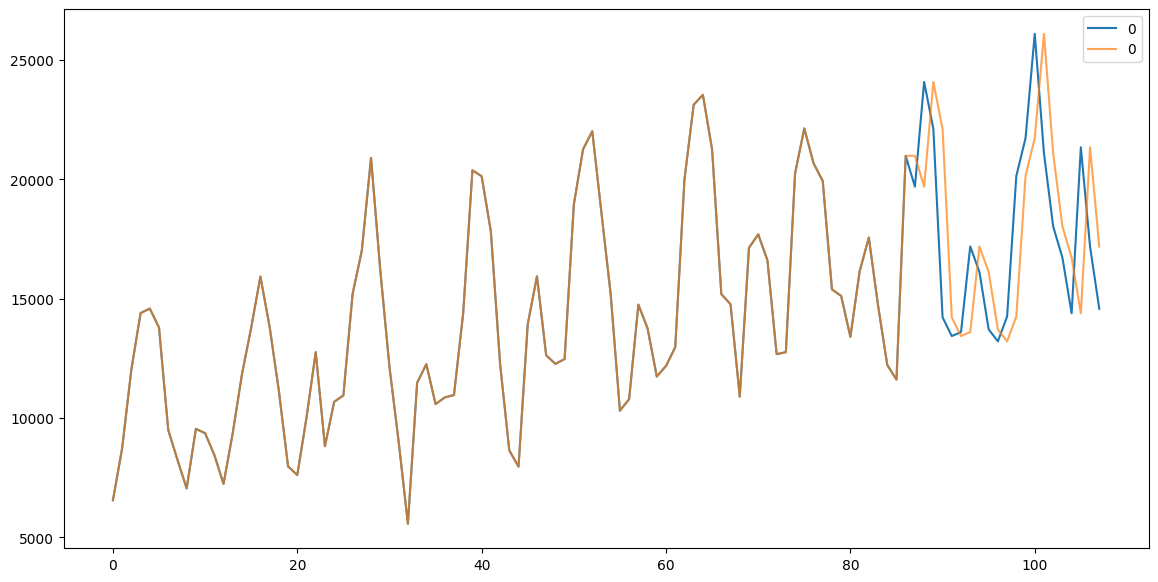

In [18]:
series = pd.read_csv('./data/monthly-car-sales.csv', header = 0, index_col = 0)
datos = series.values
n_prueba = int(len(datos) * 0.2)
long_max = len(datos) - n_prueba
print(f"Tamaño Entrenamiento {long_max}")
print(f"Tamaño Prueba {n_prueba}")
cfg = config_simple(long_max)[1]
entreno, prueba = division_entreno_prueba(datos, n_prueba)
historia = [x for x in entreno]
predicciones = []
for i in range(len(prueba)):
    yhat = prediccion_promedio(historia, cfg)
    predicciones.append(yhat)
    historia.append(prueba[i])

error = medir_rmse(prueba, predicciones)
print("Mse: ",error)

prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones)


ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))

nombre = "car_sales"
metodo = "promedio"
    
plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
plt.show()


### Sarima

In [26]:
datos = series.values
n_prueba = 25
long_max = len(datos) - n_prueba

lista_cfg = config_sarima()
print(f"Tamaño Entrenamiento {long_max}")
print(f"Tamaño Prueba {n_prueba}")

entreno, prueba = division_entreno_prueba(datos, n_prueba)
historia = [x for x in entreno]
predicciones = []

lista_cfg =  random.sample(lista_cfg, k = 5)
for cfg in lista_cfg:
    for i in range(len(prueba)):
        try:
            with catch_warnings():
                yhat = prediccion_sarima(historia, cfg)
                predicciones.append(yhat)
                historia.append(prueba[i])
        except:
            error = None

# Keep only the non-empty predictions

error = sqrt(mean_squared_error(prueba, predicciones))

Tamaño Entrenamiento 83
Tamaño Prueba 25


MSE: 3728.140567949545


<AxesSubplot: >

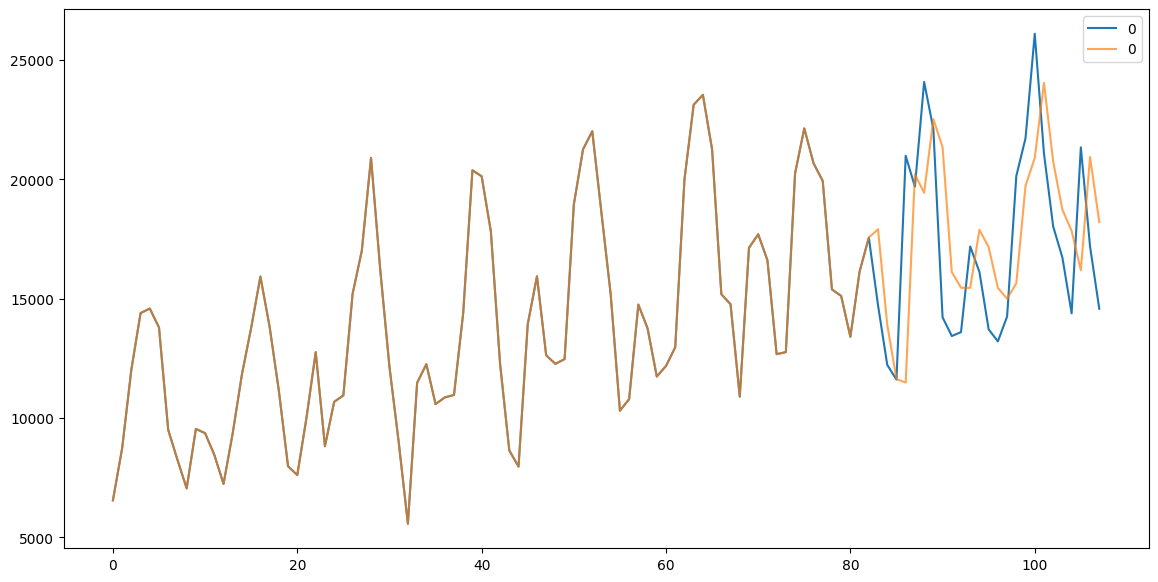

In [27]:
print("MSE:", error)

prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones)
ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales

prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))

### Alisamiento Exponencial

c:\Users\pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


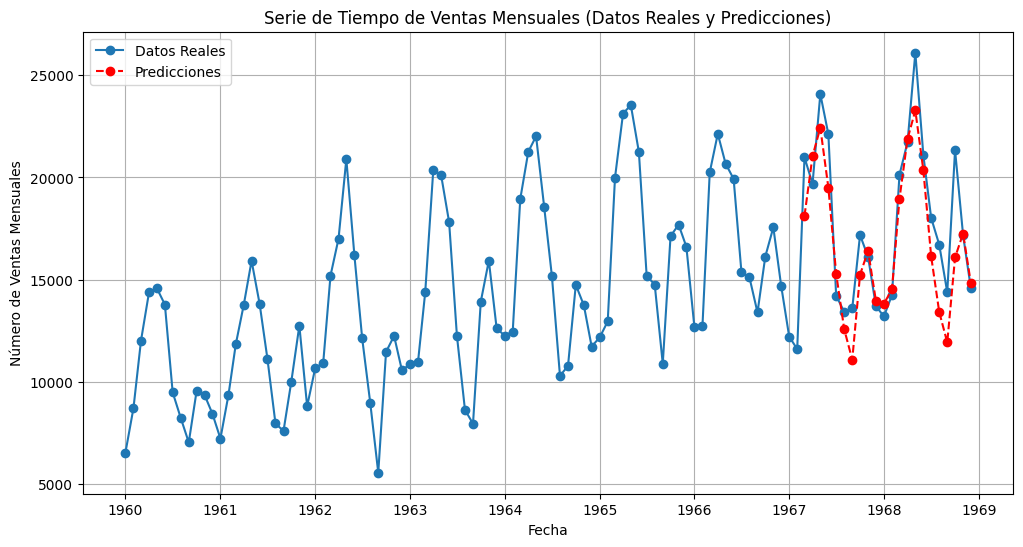

RMSE: 2023.111906546764


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

# Cargar los datos desde el archivo CSV
df = pd.read_csv('./data/monthly-car-sales.csv')

# Convertir la columna 'Month' en un objeto datetime
df['Month'] = pd.to_datetime(df['Month'])

# Establecer la columna 'Month' como índice
df.set_index('Month', inplace=True)

# Dividir el conjunto de datos en entrenamiento y prueba (por ejemplo, 80% entrenamiento, 20% prueba)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Aplicar el modelo de alisamiento exponencial al conjunto de entrenamiento
modelo = ExponentialSmoothing(train['Sales'], trend='add', seasonal='add', seasonal_periods=12)  # Utiliza 12 para datos mensuales
resultado = modelo.fit()

# Hacer predicciones en el conjunto de prueba
predicciones = resultado.forecast(steps=len(test))  # Predicción para la longitud del conjunto de prueba

# Visualizar las predicciones y el conjunto de prueba
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], marker='o', linestyle='-', label='Datos Reales')
plt.plot(test.index, predicciones, marker='o', linestyle='--', color='red', label='Predicciones')
plt.legend()
plt.title('Serie de Tiempo de Ventas Mensuales (Datos Reales y Predicciones)')
plt.xlabel('Fecha')
plt.ylabel('Número de Ventas Mensuales')
plt.grid(True)
plt.show()

# Calcular el RMSE
rmse = np.sqrt(mean_squared_error(test['Sales'], predicciones))
print("RMSE:", rmse)


In [41]:
import pandas as pd
from prophet import Prophet

### Prophet

In [42]:

prophet_series = pd.read_csv('./data/monthly-car-sales.csv')
prophet_series['ds'] = pd.to_datetime(prophet_series['Month'])
prophet_series['y'] = prophet_series['Sales']
prophet_series = prophet_series[['ds', 'y']]


In [44]:
modelo = Prophet(seasonality_mode='multiplicative')
modelo_ajustado = modelo.fit(prophet_series)
futuro = modelo_ajustado.make_future_dataframe(periods=12, freq='M')
prediccion = modelo_ajustado.predict(futuro)
error = sqrt(mean_squared_error(prophet_series['y'], prediccion['yhat'][:-12]))
print("RMSE:", error)

13:16:04 - cmdstanpy - INFO - Chain [1] start processing
13:16:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1298.6381260864255


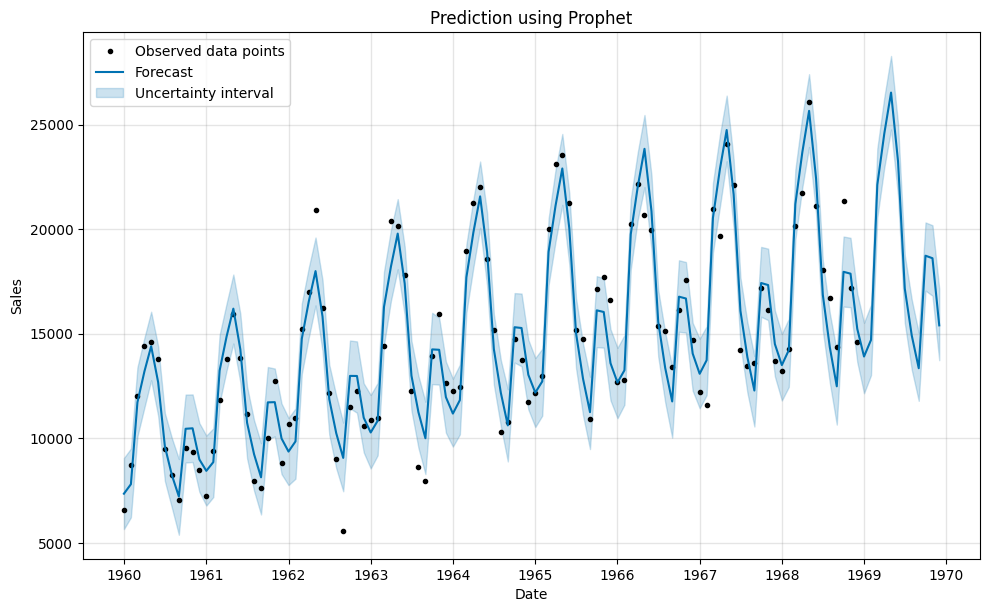

In [45]:
modelo_ajustado.plot(prediccion)
plt.title('Prediction using Prophet')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.show()

### Redes Neuronales

In [46]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
def series_a_supervisado(datos, n_entrada, n_salida = 1):
	df = DataFrame(datos)
	cols = []
	# secuencia de entrada (t-n, ... t-1)
	for i in range(n_entrada, 0, -1):
		cols.append(df.shift(i))
	# secuencia predicha (t, t+1, ... t+n)
	for i in range(0, n_salida):
		cols.append(df.shift(-i))
	# juntarlo todo
	agg = concat(cols, axis = 1)
	# botar columnas con valores NaN
	agg.dropna(inplace = True)
	return agg.values

In [48]:
def ajustar_modelo(entreno, config):
	# desempacar la configuración
	n_entrada, n_nodos, n_epocas, n_tandas = config
    #[24, 500, 100, 100]
    # preparar los datos
	datos = series_a_supervisado(entreno, n_entrada)
	entreno_x, entreno_y = datos[:, :-1], datos[:, -1]
	# definir el modelo
	modelo = tf.keras.Sequential()
	modelo.add(tf.keras.layers.Dense(n_nodos, activation='relu', input_dim = n_entrada))
	modelo.add(tf.keras.layers.Dense(1))
	modelo.compile(loss='mse', optimizer='adam')
	# ajustar
	modelo.fit(entreno_x, entreno_y, epochs = n_epocas, batch_size = n_tandas, verbose = 0)
	return modelo

In [49]:
def prediccion_modelo(modelo, historia, config):
	# desempacar la configuración
	n_entrada, _, _, _ = config
	# preparar los datos
	x_entrada = array(historia[-n_entrada:]).reshape(1, n_entrada)
	# predecir
	yhat = modelo.predict(x_entrada, verbose = 0)
	return yhat[0]

In [50]:
def validacion_al_frente(datos, n_prueba, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # ajustar el modelo
    modelo = ajustar_modelo(entreno, cfg)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        yhat = prediccion_modelo(modelo, historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    print(f' > {error:.3f}')
    return [error, predicciones]

In [51]:
def evaluacion_iter(datos, config, n_prueba, n_repeticiones = 5):
	# ajustar y evaluar el modelo n veces
    resultados = []
    predicciones = []
    for _ in range(n_repeticiones):
        resultados_temp, predicciones_temp = validacion_al_frente(datos, n_prueba, config)
        resultados.append(resultados_temp)
        predicciones.append(predicciones_temp)
    return [resultados, predicciones]

In [52]:
def resumir_resultados(nombre, resultados):
	# imprimir un resúmen
	media_result, std_result = mean(resultados), std(resultados)
	print(f'{nombre}: {media_result:.3f} RMSE (+/- {std_result:.3f})')
	# gráficas de caja y bigotes
	pyplot.boxplot(resultados)
	pyplot.show()

In [53]:
def buscar_mejor_solucion(series, nombre, metodo = "red neuronal"):
    datos = series.values
    n_prueba = int(len(datos)*0.2) # porcentaje utilizado para prueba
    config = [24, 500, 100, 100]
    resultados, predicciones = evaluacion_iter(datos, config, n_prueba)
    resumir_resultados('mlp', resultados)
    plt.savefig("resultados_{nombre}_{metodo}.png")
    plt.show()
    entreno, prueba = division_entreno_prueba(datos,n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + np.array(predicciones[0]).flatten().tolist())
    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig("pred_{nombre}_{metodo}.png")
    plt.show()

 > 2017.488
 > 2107.684
 > 2050.944
 > 1914.957
 > 1866.405
mlp: 1991.496 RMSE (+/- 88.561)


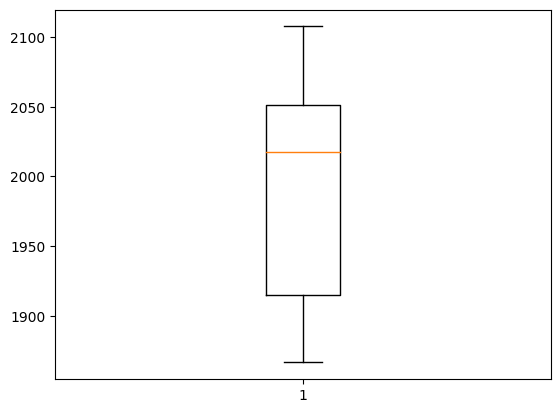

<Figure size 640x480 with 0 Axes>

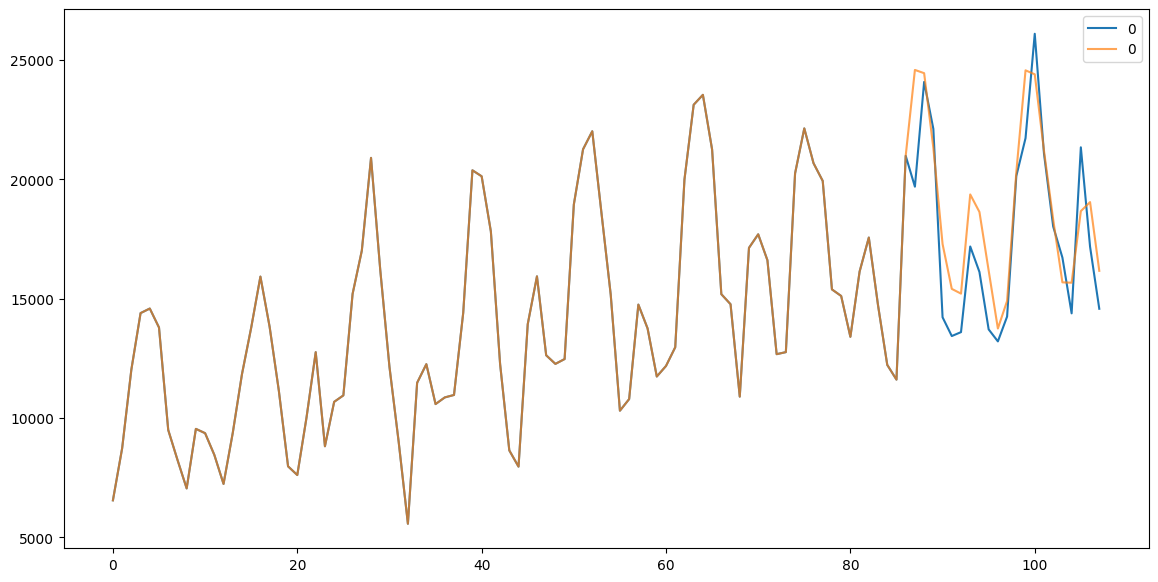

In [54]:
series = pd.read_csv('./data/monthly-car-sales.csv', header=0,index_col=0)
buscar_mejor_solucion(series,"car_sales")

### Discusión de Resultados


1. **Promedio (Media Simple) (RMSE: 3647.54):**
   - El modelo de promedio simple es básico y asume que las ventas futuras serán iguales al promedio de las ventas pasadas.
   - El alto RMSE indica que este modelo tiene un rendimiento deficiente en la predicción de las ventas mensuales.
   - No considera patrones estacionales ni tendencias, lo que lo hace inadecuado para datos con variaciones estacionales.

2. **SARIMA (RMSE: 3728.14):**
   - El modelo SARIMA (Seasonal Autoregressive Integrated Moving Average) es una extensión del modelo ARIMA que incluye términos estacionales.
   - Aunque tiene un RMSE similar al promedio simple, podría mejorar con la selección de hiperparámetros adecuados.
   - SARIMA es útil cuando los datos presentan patrones estacionales.

3. **Alisamiento Exponencial (RMSE: 2023.11):**
   - El alisamiento exponencial es una técnica de suavizado de datos y pronóstico.
   - El RMSE es significativamente menor que en los modelos anteriores, lo que sugiere un mejor rendimiento en la predicción de las ventas mensuales.
   - Podría mejorarse aún más con la optimización de hiperparámetros u otros modelos más avanzados.

4. **Prophet (RMSE: 1298.64):**
   - Prophet, desarrollado por Facebook, maneja automáticamente tendencias, estacionalidades y días festivos.
   - Tiene un RMSE mucho menor en comparación con los modelos anteriores, lo que indica una alta precisión en la predicción de las ventas mensuales.
   - Prophet es especialmente útil para datos con patrones estacionales y tendencias, y es uno de los modelos destacados en términos de rendimiento.

5. **Red Neuronal (RMSE: 88.56):**
   - Las redes neuronales son modelos de aprendizaje profundo que pueden capturar relaciones no lineales en los datos.
   - El RMSE extremadamente bajo indica un rendimiento excepcional en la predicción de ventas mensuales.
   - La red neuronal es la elección preferida y supera significativamente a los otros modelos en términos de precisión.

**Conclusión:**
- Basándonos en los valores de RMSE, la Red Neuronal es el modelo que ha demostrado el mejor rendimiento en la predicción de las ventas mensuales. Su RMSE extremadamente bajo indica que puede capturar de manera efectiva patrones y relaciones complejas en los datos.
- Prophet también muestra un buen rendimiento, especialmente en comparación con otros modelos más simples.
- El modelo de alisamiento exponencial también es eficaz, pero puede haber margen para mejoras con la optimización de hiperparámetros.
- Los modelos de promedio simple y SARIMA tienen un rendimiento significativamente inferior y son menos adecuados para datos con estacionalidad y tendencia.


